In [1]:
import pandas as pd
from pycaret.classification import *
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
import os

In [2]:
#load data
os.chdir('../..')
df=pd.read_csv('./data/csv/graph-features-reduced.csv')
#drop node and cluster columns
df.drop(['node','cluster'],axis=1,inplace=True)
#rename label values botnet to 1 and normal to zero
df['label'].replace({'botnet':1,'normal':0},inplace=True)

In [3]:
#train logistic regression model with all numerical features
classif = setup(data = df, target = 'label', session_id=123, train_size=0.8,numeric_features=['ID','OD','IDW','ODW','LCC','AC','BC'],silent=True,remove_perfect_collinearity=False)

,Description,Value
0,session_id,123
1,Target,label
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(18693, 8)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [4]:
#add balanced accuracy metric
add_metric('balanced_accuracy', 'Balanced Accuracy', balanced_accuracy_score, greater_is_better=True)

#Add specificity metric
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel() #ravel flattens the array
    specificity = tn / (tn+fp)
    return specificity
    
add_metric('specificity', 'Specificity', specificity_score, greater_is_better=True)
print('')



In [5]:
#Now we pick the best model and test it
rf2=create_model('rf',max_features=2,max_depth=3,n_estimators=100,class_weight='balanced')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balanced Accuracy,Specificity
Fold,,,,,,,,,
0,0.9318,0.9742,1.0000,0.0192,0.0377,0.0352,0.1339,0.9659,0.9317
1,0.9057,0.9896,1.0000,0.0140,0.0276,0.0250,0.1125,0.9528,0.9056
2,0.9606,0.9224,0.5000,0.0169,0.0328,0.0303,0.0866,0.7306,0.9612
3,0.9545,0.9722,1.0000,0.0286,0.0556,0.0531,0.1651,0.9772,0.9545
4,0.9171,0.9823,1.0000,0.0159,0.0312,0.0287,0.1206,0.9585,0.9169
5,0.9572,0.9099,0.5000,0.0156,0.0303,0.0278,0.0827,0.7289,0.9578
6,0.9124,1.0000,1.0000,0.0150,0.0296,0.0271,0.1171,0.9561,0.9123
7,0.9405,0.9766,1.0000,0.0220,0.0430,0.0405,0.1438,0.9702,0.9404
8,0.9151,1.0000,1.0000,0.0155,0.0305,0.0280,0.1191,0.9575,0.9149


In [6]:
#Get balanced accuracy, recall and specificity for test set
 #get pycaret test set
test_df=get_config('X_test')
test_df['label']=get_config('y_test')
test_df['prediction']=predict_model(rf2,data=test_df)['Label']

#Get balanced accuracy, recall and specificity for test set
tn, fp, fn, tp = confusion_matrix(test_df['label'], test_df['prediction']).ravel()

recall=tp/(tp+fn)
specificity=tn/(tn+fp)
balanced_acc=(recall+specificity)/2
print('Balanced Accuracy:',balanced_acc)
print('Recall:',recall)
print('Specificity:',specificity)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balanced Accuracy,Specificity
0,Random Forest Classifier,0.9446,0.9936,1.0000,0.0236,0.0461,0.0436,0.1493,0.9723,0.9446


Balanced Accuracy: 0.972281735404392
Recall: 1.0
Specificity: 0.9445634708087841


### Super bucle

In [7]:
#Save balanced accuracy and calculate its mean
bal_acc_list=[]
rec_list=[]
for iditer in range(0,100):
    df=pd.read_csv('./data/csv/graph-features-reduced.csv')
    #drop node and cluster columns
    df.drop(['node','cluster'],axis=1,inplace=True)
    #rename label values botnet to 1 and normal to zero
    df['label'].replace({'botnet':1,'normal':0},inplace=True)

    #train logistic regression model with all numerical features
    classif = setup(data = df, target = 'label', session_id=iditer, train_size=0.8,numeric_features=['ID','OD','IDW','ODW','LCC','AC','BC'],silent=True,remove_perfect_collinearity=False,data_split_stratify=True)
    #Now we pick the best model and test it
    rf2=create_model('rf',max_features=1,max_depth=2,n_estimators=100,class_weight='balanced')
    test_df=get_config('X_test')
    test_df['label']=get_config('y_test')
    test_df['prediction']=predict_model(rf2,data=test_df)['Label']

    #Get balanced accuracy, recall and specificity for test set
    tn, fp, fn, tp = confusion_matrix(test_df['label'], test_df['prediction']).ravel()

    recall=tp/(tp+fn)
    specificity=tn/(tn+fp)
    balanced_acc=(recall+specificity)/2
    rec_list.append(recall)
    bal_acc_list.append(balanced_acc)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8570,0.9116,0.5000,0.0047,0.0093,0.0066,0.0373
1,0.8750,0.9541,1.0000,0.0106,0.0209,0.0183,0.0962
2,0.8643,0.9485,1.0000,0.0098,0.0193,0.0167,0.0918
3,0.8596,0.9672,1.0000,0.0094,0.0187,0.0161,0.0900
4,0.8809,1.0000,1.0000,0.0111,0.0220,0.0194,0.0989
5,0.8742,0.9618,1.0000,0.0105,0.0208,0.0182,0.0959
6,0.8823,0.9787,1.0000,0.0112,0.0222,0.0196,0.0996
7,0.8823,0.9888,1.0000,0.0112,0.0222,0.0196,0.0996
8,0.8950,0.9468,1.0000,0.0126,0.0248,0.0223,0.1061


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8676,0.9698,1.0000,0.0100,0.0198,0.0172,0.0931


In [8]:
#calculate mean and std
print('Mean:',np.mean(bal_acc_list))
print('Std:',np.std(bal_acc_list))

Mean: 0.8894359935725764
Std: 0.06501904707069335


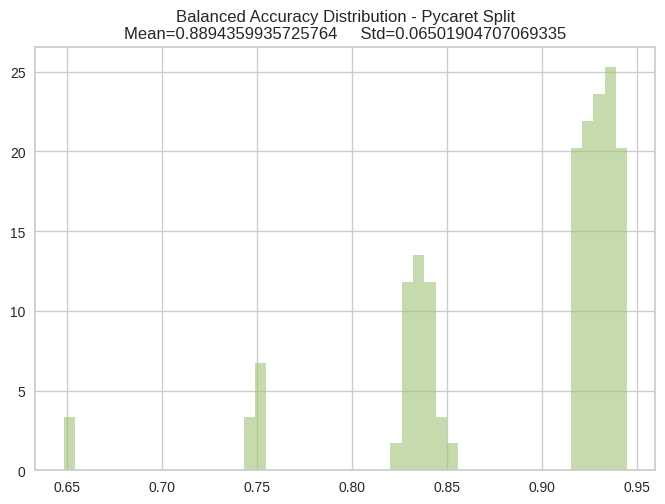

In [18]:
#plot a normal distribution with mean and std
import matplotlib.pyplot as plt
import numpy as np

#plot balanced accuracy distribution
plt.hist(bal_acc_list, bins=50, density=True, alpha=0.6, color='g')
#pycaret split title
plt.title('Balanced Accuracy Distribution - Pycaret Split\n'+'Mean='+str(np.mean(bal_acc_list))+'     Std='+str(np.std(bal_acc_list)))
#legend with my mean and std
plt.show()
